# DNABERT Quick start
Following the steps from the **Quick Start** section from the [official repository](https://github.com/Zhihan1996/DNABERT_2).

In [1]:
import torch
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, DataCollatorWithPadding
from datasets import Dataset
from torch.utils.data import dataset, DataLoader

In [2]:
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M")
model = AutoModelForSequenceClassification.from_pretrained("zhihan1996/DNABERT-2-117M", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.9.attention.self.key.weight', 'bert.encoder.layer.5.attention.self.query.bias', 'bert.encoder.layer.6.intermediate.dense.bias', 'bert.encoder.layer.1.intermediate.dense.bias', 'bert.encoder.layer.1.attention.self.value.bias', 'bert.encoder.layer.10.output.dense.weight', 'bert.encoder.layer.5.output.dense.bias', 'bert.encoder.layer.8.attention.self.value.bias', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.3.attention.self.key.bias', 'bert.encoder.layer.6.output.LayerNorm.weight', 'bert.encoder.layer.2.intermediate.dense.weight', 'bert.encoder.layer.10.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.6.output.dense.bias', 'bert.encoder.layer.11.intermediate.dense.bias', 'bert.encoder.layer.8.intermediat

In [4]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(4096, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

## Calculate the embedding of a DNA sequence

In [11]:
dna = "ACGTAGCATCGGATCTATCTATCGACACTTGGTTATCGATCTACGAGCATCTCGTTAGC"
inputs = tokenizer(dna, return_tensors = 'pt')["input_ids"]
hidden_states = model(inputs)[0] # [1, sequence_length, 768]
hidden_states

tensor([[ 0.0102, -0.1952]], grad_fn=<AddmmBackward0>)

# Train with my dataset

In [5]:
import os
import pandas as pd
databases_path = "/mnt/sda1/Databases/"
# Ensembl Variation path
ensembl_path = os.path.join(databases_path, "Ensembl/Variation/110/")
chr2_dataset = pd.read_csv(os.path.join(ensembl_path, 'to_dataloaders/chr2_dataset.csv'), index_col=0)
chr2_dataset.head()

,seq,label
0,TTCTTTTAAATGGCTACATAATTAAGTCTAAGGTGAGAATTACTGT...,0
1,AGTATTATTTCTATTCTTTACTTGAGAATCCAGTTTTGTAGGACTT...,0
2,ATTTTTTTTTTTCGAGTCAGAGTCTTGTTCTGTCACCCAGGCTGGA...,0
3,CTGCTTTGGGTTCTGCTGAAATCATGGATGAGTTCTTTCTTTAAAT...,0
4,ATTAATATTTACCCTGTATATTTTCACAGGACCATTATATTGATCA...,0


## Dataset and DataLoaders

In [6]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# Using the HuggingFace framework to create the Datasets and DataLoaders and split the data into train and test set
hf_dataset = Dataset.from_pandas(chr2_dataset).train_test_split(test_size=0.3)
hf_dataset

DatasetDict({
    train: Dataset({
        features: ['seq', 'label', '__index_level_0__'],
        num_rows: 46102
    })
    test: Dataset({
        features: ['seq', 'label', '__index_level_0__'],
        num_rows: 19758
    })
})

In [7]:
def tokenize_function(example):
    return tokenizer(example["seq"], truncation=True)

tokenized_datasets = hf_dataset.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/46102 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/19758 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['seq', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 46102
    })
    test: Dataset({
        features: ['seq', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 19758
    })
})

In [8]:
tokenized_datasets = tokenized_datasets.remove_columns(["seq", "__index_level_0__"])
tokenized_datasets.set_format("torch")
tokenized_datasets.column_names

{'train': ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
 'test': ['label', 'input_ids', 'token_type_ids', 'attention_mask']}

### Create the DataLoaders

In [9]:
train_set = DataLoader(tokenized_datasets["train"], batch_size=8, shuffle=True, collate_fn=data_collator)
test_set = DataLoader(tokenized_datasets["test"], batch_size=8, shuffle=True, collate_fn=data_collator)

Inspect the first batch from the DataLoaders:

In [10]:
for batch in train_set:
    break
{k: v.shape for k, v in batch.items()}

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': torch.Size([8, 34]),
 'token_type_ids': torch.Size([8, 34]),
 'attention_mask': torch.Size([8, 34]),
 'labels': torch.Size([8])}

In [11]:
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(0.6766, grad_fn=<NllLossBackward0>) torch.Size([8, 2])


In [13]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [14]:
from transformers import get_scheduler

num_epochs = 10
num_training_steps = num_epochs * len(train_set)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

57630


# The training loop

In [15]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [16]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
train_losses = []
model.train()
for epoch in range(num_epochs):
    total_loss = 0

    for batch in train_set:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        total_loss += loss
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    average_loss = total_loss / len(train_set)
    train_losses.append(average_loss)


  0%|          | 0/57630 [00:00<?, ?it/s]

## Evaluate the model

In [23]:
import evaluate

metric = evaluate.load("accuracy")
model.eval()
for batch in test_set:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])
metric.compute()

{'accuracy': 0.6420690353274623}

In [66]:
# Save the model
#torch.save(model.state_dict(), "DNABERT2_REF_VS_ALT_SEQUENCES.pth")

In [98]:
for batch in test_set:
    batch = {k: v.to(device) for k, v in batch.items()}
    break
batch

{'input_ids': tensor([[   1, 3174, 3795,  321, 3302,   17,  286, 1573, 2409, 1652,  196,   24,
           166,  674,  212,  288,   77,  216,   28,  784,  110,  589,   95, 1457,
            95, 1038,    2,    3,    3],
         [   1,    9,  211,  152,  354, 2735,  111, 1005, 1814, 1717,  890,  138,
           367,  555,  117,  690,  667, 3879,   30,  495, 1382,  140,  295, 1262,
            28,    2,    3,    3,    3],
         [   1,   51,  152,   40,  177,   43,  230, 1688,  392,  115,  173,   82,
           116,   59, 1113,   30, 2592,   80,  341,   26, 1927,  372,   14,  806,
           259, 3999, 4089,    2,    3],
         [   1, 1713,  242,   58,   79,  606,  755,   29,  597, 2970, 3279,  594,
          2193,  167,  287,  892,  116,  406,   51,  383,   46,  498,  741,  236,
             2,    3,    3,    3,    3],
         [   1,   87,  142, 2626,  279,   86,   23,  207,   45,  113,   20,  186,
           352,  319,  787,   70,  245, 3190,  929,  197,   45,  244,   46, 3854,
   

In [55]:
model.eval()
outputs = model(**batch)
outputs.logits

tensor([[ 0.3734, -0.1983],
        [ 0.3734, -0.1983],
        [ 0.3734, -0.1983],
        [ 0.3734, -0.1983],
        [ 0.3734, -0.1983],
        [ 0.3734, -0.1983]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [56]:
predictions = torch.argmax(logits, dim=-1)
truth = batch['labels']
print(predictions, truth)

tensor([0, 0, 0, 0, 0, 0], device='cuda:0') tensor([0, 0, 0, 0, 0, 0], device='cuda:0')


In [67]:
model.eval()
pred = model(batch['input_ids'])
truth = batch['labels']
print(pred, truth)

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.3734, -0.1983],
        [ 0.3734, -0.1983],
        [ 0.3734, -0.1983],
        [ 0.3734, -0.1983],
        [ 0.3734, -0.1983],
        [ 0.3734, -0.1983]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None) tensor([0, 0, 0, 0, 0, 0], device='cuda:0')


In [20]:
import seaborn as sns
import numpy as np

In [77]:
losses = [loss.detach().numpy() for loss in losses]

In [17]:
new_losses = []
for loss in train_losses:
    new_losses.append(loss.item())

In [18]:
new_losses[:5]

[0.6620619297027588,
 0.656906008720398,
 0.654563844203949,
 0.6549801230430603,
 0.6536880731582642]

<Axes: xlabel='epoch', ylabel='loss'>

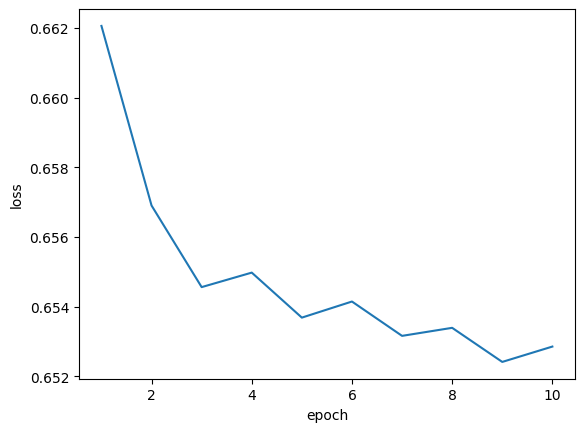

In [22]:
data = {
    'epoch': [1,2,3,4,5,6,7,8,9,10],
    'loss': new_losses
}

sns.lineplot(data=data, x='epoch', y='loss')